## Group Name : Unfiltered Commentary

- Raees Moosa : 2322203
- Oriinga Maudu : 2433303
- Tumi Jourdan : 2180153

In [116]:
import numpy as np
import imageio
from glob import glob
from skimage import img_as_float32
from natsort import natsorted
import matplotlib.pyplot as plt
import cv2
from typing import Tuple
import json
from collections import defaultdict

In [117]:
path_pairs = list(zip(
natsorted(glob('./puzzle_corners_1024x768/images-1024x768/*.png')),
natsorted(glob('./puzzle_corners_1024x768/masks-1024x768/*.png')),
))
imgs = np.array([img_as_float32(imageio.imread(ipath)) for ipath, _ in path_pairs])
msks = np.array([img_as_float32(imageio.imread(mpath)) for _, mpath in path_pairs])

C:\Users\Oriin\AppData\Local\Temp\ipykernel_27284\1865243255.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs = np.array([img_as_float32(imageio.imread(ipath)) for ipath, _ in path_pairs])
C:\Users\Oriin\AppData\Local\Temp\ipykernel_27284\1865243255.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  msks = np.array([img_as_float32(imageio.imread(mpath)) for _, mpath in path_pairs])


In [118]:
def get_puzzle_contour(mask):
    mask_uint8 = cv2.convertScaleAbs(mask)
    return cv2.findContours(mask_uint8,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [119]:
def get_clockwise_contour(contours):
    if cv2.contourArea(contours,oriented=True)<0:
        return contours[::-1]
    return Tuple(contours)

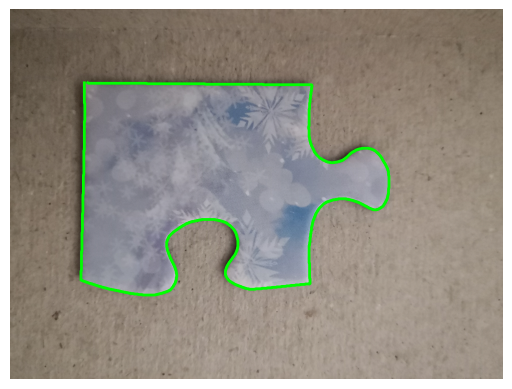

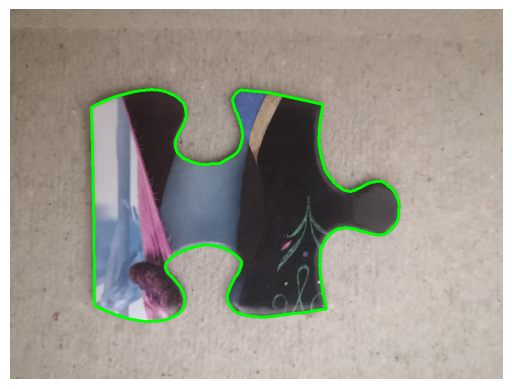

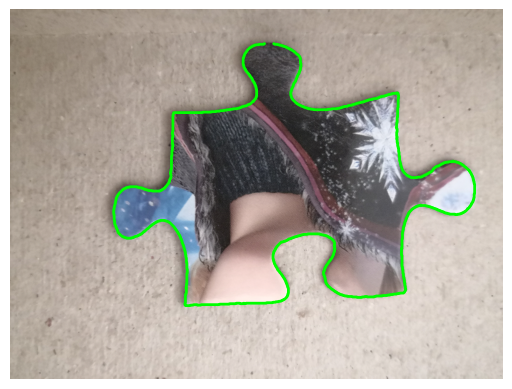

In [120]:
#Show Contours
for i in range(3):
    contours, hier = get_puzzle_contour(msks[i])
    contours = np.squeeze(get_clockwise_contour(contours[0]))
    # Create the figure and axis
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(imgs[i], cmap='gray')

    # Plot the coordinates
    x_coords, y_coords = zip(*contours)
    ax.plot(x_coords, y_coords, c='lime', linewidth=2)
    ax.axis('off')
    plt.show()


In [127]:
with open("./puzzle_corners_1024x768/corners.json", mode="r") as f:
    names, corner_ratios = json.load(f)

#Convert Ratios to coordinates
for picture in range(len(corner_ratios)):
    for points in range(len(corner_ratios[picture])):
        corner_ratios[picture][points]=[corner_ratios[picture][points][0]*1024,corner_ratios[picture][points][1]*768]    

In [176]:
def extract_sides(contours, corners):
    corner_dists=[]
    for corner in corners:
        corner_dists.append(np.linalg.norm(contours - corner, axis=-1))

    corner_dists = np.swapaxes(np.array(corner_dists),0,1)    

    #Get indeices of 2 closest corners
    corner_indices = np.argpartition(np.squeeze(corner_dists), 2, axis=-1)[:,:2]

    sides = defaultdict(list)
    for i in range(corner_indices.shape[0]):
        sides[tuple(sorted(corner_indices[i]))].append(contours[i])

    for side in sides:
        sides[side].insert(0,corners[list(side)[0]])
        sides[side].append(corners[list(side)[1]])
    
    return sides



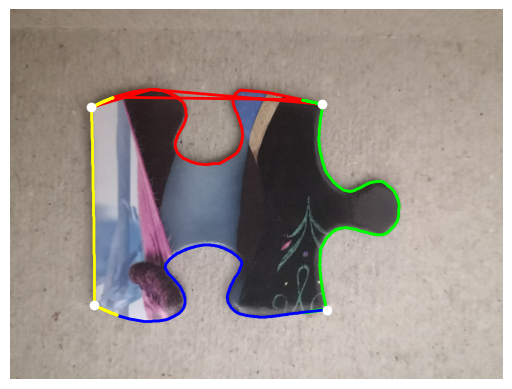

In [183]:
contours, hier = get_puzzle_contour(msks[1])
contours = np.squeeze(get_clockwise_contour(contours[0]))
sides = extract_sides(contours,corner_ratios[1])

# Create the figure and axis
fig, ax = plt.subplots()

# Display the image
ax.imshow(imgs[1], cmap='gray')

#plot corners
x_coords, y_coords = zip(*(corner_ratios[1]))
ax.scatter(x_coords, y_coords, c='white',zorder=2)

#plot contour
#x_coords, y_coords = zip(*(contours))
#ax.scatter(x_coords, y_coords, c='white', s=2,zorder=2)


# Plot the coordinates
x_coords, y_coords = zip(*list(sides.values())[0])
ax.plot(x_coords, y_coords, c='red', linewidth=2,zorder=1)

x_coords, y_coords = zip(*list(sides.values())[1])
ax.plot(x_coords, y_coords, c='lime', linewidth=2,zorder=1)

x_coords, y_coords = zip(*list(sides.values())[2])
ax.plot(x_coords, y_coords, c='blue', linewidth=2,zorder=1)

x_coords, y_coords = zip(*list(sides.values())[3])
ax.plot(x_coords, y_coords, c='yellow', linewidth=2,zorder=1)



ax.axis('off')
plt.show()
